In [1]:
%load_ext autoreload
%autoreload 2
# imports

# important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

from tqdm.auto import tqdm
import itertools

# for better printing of variables
from IPython.display import display

# custom imports
from concperf import single_model, general_model
from concperf import utility

In [2]:
# target utilization
target_util = 0.7


model_config = {
    # 'instance_count' should be added for each state
    'max_conc': 10,
    'arrival_rate_total': 1,
    'alpha': 0.11,
    'base_service_time_ms': 1154,
    'max_container_count': 25,
    'target_conc': 1*target_util, # assumes target utilization
    'max_scale_up_rate': 1000, # from N to 1000*N at most
    'max_scale_down_rate': 2, # from N to N/2 at most
    # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
    'autoscaling_interval': 2, # amount of time between autoscaling evaluations
    'provision_rate_base': 1,
    'deprovision_rate_base': 2,
}

# test
# model_config = {
#     # 'instance_count' should be added for each state
#     'max_conc': 100,
#     'arrival_rate_total': 15,
#     'alpha': 1,
#     'base_service_time_ms': 400,
#     'max_container_count': 25,
#     'target_conc': 16*0.7, # assumes target utilization
#     'max_scale_up_rate': 1000, # from N to 1000*N at most
#     'max_scale_down_rate': 2, # from N to N/2 at most
#     # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
#     'autoscaling_interval': 2, # amount of time between autoscaling evaluations
#     'provision_rate_base': 1,
#     'deprovision_rate_base': 2,
# }

In [3]:
avg_multipliers = list(range(1, 21, 2))
results = []
for avg_multiplier in avg_multipliers:
    # update configuration dictionary for each instance count
    def update_config(config):
        config['arrival_rate_server'] = config['arrival_rate_total'] / config['instance_count']
        config['base_service_time'] = config['base_service_time_ms'] / 1000
        config['stable_conc_avg_count'] = avg_multiplier * config['instance_count']

    res = general_model.solve_general_model(model_config, update_config, show_progress=True)
    results.append(res)

100%|██████████| 26/26 [00:14<00:00,  1.74it/s]


In [4]:
def parse_res(res):
    req_count_probs_weighted = res['req_count_probs'].T @ res['ready_probs']
    req_count_avg = (res['req_count_values'] * req_count_probs_weighted).sum()
    ready_avg = (res['inst_count_possible_values'] * res['ready_probs']).sum()
    ordered_avg = (res['inst_count_possible_values'] * res['ordered_probs']).sum()
    resp_time_counts = res['req_count_values'][1:]
    resp_time_counts_probs = req_count_probs_weighted[1:] / (1- req_count_probs_weighted[0])
    resp_time_values = model_config['base_service_time_ms'] * (1 + (resp_time_counts - 1) * model_config['alpha'])
    resp_time_avg = (resp_time_values * resp_time_counts_probs).sum()
    return {
        'ready_avg': ready_avg,
        'ordered_avg': ordered_avg,
        'resp_time_avg': resp_time_avg,
        'req_count_avg': req_count_avg,
    }

parsed_res = list(map(parse_res, results))
parsed_res = pd.DataFrame(data=parsed_res)

In [5]:
parsed_res.head()

,ready_avg,ordered_avg,resp_time_avg,req_count_avg
0,2.111794,2.210273,1229.452194,0.778363
1,2.087369,2.153071,1224.002744,0.746273
2,2.161420,2.208758,1212.334448,0.659054
3,2.283164,2.324873,1204.957077,0.597232
4,2.227170,2.266543,1206.180566,0.611808


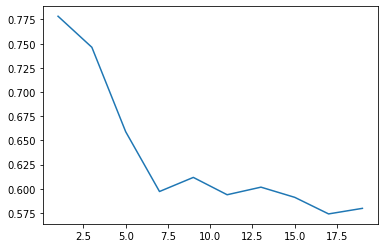

In [6]:
plt.plot(avg_multipliers, parsed_res['req_count_avg'])